# The Chaotic Chef’s Quest: Learning to Cook the Perfect Meal
### Final Project in the Subject: Reinforcement Learning

**Julia Maria Wdowinska**  
Data Science for Economics  
II year  
Master’s Degree  
Matriculation Number: 43288A

## Introduction

In this project, the agent acts as a **chef exploring city markets arranged in a 5×5 grid**, where each cell offers a **unique ingredient**. The chef collects ingredients from a limited supply to prepare dishes, with different recipes requiring specific ingredient combinations. Some ingredient pairs **complement each other**, while others **cause penalties** if combined.

The agent must navigate the grid to gather ingredients and decide the optimal time to **stop and cook**, aiming to **maximize the dish’s total value** while **minimizing wasted ingredients**.

An extended variant introduces a **monetary budget**, where each ingredient has a **cost** and dishes generate **revenue** based on their quality. Here, the agent’s goal shifts to **maximizing overall wealth under budget constraints**.

In [1]:
# Import necessary libraries and agent classes
import pickle
import gymnasium as gym
import UDFs
from UDFs import SARSAAgent, DDQNAgent, BudgetedDDQNAgent, BudgetedLinearSARSAAgent
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch

In [2]:
# Function to smooth data using a moving average with a specified window
def conv(data, win=500):
    return np.convolve(data, np.ones(win) / win, mode='same')

# Function to plot some statistics collected during agent training
def plot_agent_logs(agent, wrapped_env, episodes, use_td_errors=False):
    logs = agent.logs
    cwin = max(1, int(episodes / 200))

    _, axs = plt.subplots(3, 2, figsize=(14, 10))
    axs = axs.flatten()

    sns.lineplot(x=range(episodes), y=logs["epsilons"], ax=axs[0])
    axs[0].set_title("Epsilon Decay")

    sns.lineplot(x=range(episodes), y=conv(wrapped_env.length_queue, win=cwin), ax=axs[1])
    #sns.lineplot(x=range(episodes), y=conv(logs["episode_lengths"], win=cwin), ax=axs[1])
    axs[1].set_title("Episode Length (Smoothed)")

    sns.lineplot(x=range(episodes), y=conv(logs["invalid_actions"]), ax=axs[2])
    axs[2].set_title("Invalid Actions (Smoothed)")

    sns.lineplot(x=range(episodes), y=conv(wrapped_env.return_queue, win=cwin), ax=axs[3])
    #sns.lineplot(x=range(episodes), y=conv(logs["episode_rewards"], win=cwin), ax=axs[3])
    axs[3].set_title("Episode Reward (Smoothed)")

    loss_key = "td_errors" if use_td_errors else "losses"
    sns.lineplot(x=range(episodes), y=conv(logs[loss_key], win=cwin), ax=axs[4])
    axs[4].set_title("Average " + ("TD Error (Smoothed)" if use_td_errors else "Loss (Smoothed)"))

    sns.lineplot(x=range(episodes), y=conv(logs["final_cooking_rewards"], win=cwin), ax=axs[5])
    axs[5].set_title("Final Cooking Reward (Smoothed)")

    plt.tight_layout()
    plt.show()

# Function to print summary statistics of metrics collected during agent training
def print_log_stats(agent, use_td_errors=False):
    logs = agent.logs
    
    loss_key = "td_errors" if use_td_errors else "losses"
    variables = [
        ("epsilons", "Epsilon Decay"),
        ("episode_lengths", "Episode Length"),
        ("invalid_actions", "Invalid Actions"),
        ("episode_rewards", "Episode Reward"),
        (loss_key, "Average " + ("TD Error" if use_td_errors else "Loss")),
        ("final_cooking_rewards", "Final Cooking Reward")
    ]
    
    print(f"{'Metric':<25} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    print("-" * 81)
    
    for key, label in variables:
        data = logs[key]
        mean = np.mean(data)
        std = np.std(data)
        min_val = np.min(data)
        max_val = np.max(data)
        
        print(f"{label:<25} {mean:10.2f} {std:10.2f} {min_val:10.2f} {max_val:10.2f}")

# Function to run a full episode using a given action selection function
def evaluate_agent(env, select_action_fn):
    state, _ = env.reset()
    done = False

    total_reward = 0
    steps = 0

    while not done:
        action = select_action_fn(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        total_reward += reward
        steps += 1
        done = terminated or truncated
        state = next_state

    print(f"\nTotal reward: {total_reward:.2f}, Steps taken: {steps}")

# Function to return a greedy action selector using the trained DDQN agent
def ddqn_greedy_action(agent):
    def select_action(state):
        state_tensor = torch.tensor(agent.preprocess_state(state), dtype=torch.float32).unsqueeze(0).to(agent.device)
        with torch.no_grad():
            q_values = agent.online_net(state_tensor)
        return torch.argmax(q_values).item()
    return select_action

# Function to return a greedy action selector using the trained SARSA agent
def sarsa_greedy_action(agent):
    return lambda state: agent.greedy_policy(state)

# Function to return a random action selector
def random_action(env):
    return lambda state: env.action_space.sample()

## Data Collection and Preprocessing

The dataset used in this project comes from the Kaggle repository [Food Recipes](https://www.kaggle.com/datasets/sarthak71/food-recipes). It contains a wide range of **recipes** with features such as the number of ratings, **average rating**, cuisine, course, preparation time, **ingredients**, instructions, author, and category.

The objective is to extract a subset of recipes such that the total number of **unique ingredients** is **exactly 25**, allowing for the construction of a **5x5 ingredient grid** used in the environment.

The following steps were performed ([data-processing.py](./data-processing.py)):
1. The dataset was filtered to include only **Pasta Recipes**.
2. The selected columns were: `recipe_title`, `ingredients`, and `rating`.
3. The `ingredients` column was preprocessed as follows:  
   - Ingredients were originally represented as strings containing multiple items separated by delimiters such as `|` (e.g., `"Onion|Bacon"`) or by the word `and` (e.g., `"salt and pepper"`). These strings were split into **individual ingredients** using regular expressions.  
   - Only ingredients containing **English alphabetic characters and spaces** were retained.  
   - Each ingredient was converted to **lowercase** and **lemmatized** (using `WordNetLemmatizer`) to reduce words to their base noun form. This helped unify variants like `"tomatoes"` and `"tomato"`.
4. Recipes with **missing ingredient lists** after preprocessing were **discarded**.
5. From the cleaned dataset, recipes were iteratively selected so that the total number of **unique ingredients** did not exceed **25**. Each selected recipe was stored as a **tuple** containing the **title**, a frozen **set of ingredients**, and the **rating**.
6. The unique ingredients were indexed to create a **mapping** from **ingredient IDs** to **ingredient names**.
7. A **manual cost mapping** was assigned to each ingredient to support the **budget-constrained variant** of the environment.
8. The resulting data structures (**recipes**, **ingredient index**, and **cost mappings**) were **saved** to a pickle file for reuse.

In [3]:
# Load preprocessed environment data from file
with open('data/processed_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

recipes = loaded_data['recipes']
index_to_ingredient = loaded_data['index_to_ingredient']
ingredient_to_cost = loaded_data['ingredient_to_cost']

In [4]:
# List of recipes, each defined by its name, required ingredients, and rating
recipes

[('Creamy Chicken Pesto Spaghetti Pasta Recipe',
  frozenset({'basil leaf',
             'chicken breast',
             'extra virgin olive oil',
             'garlic',
             'lemon juice',
             'parmesan cheese',
             'salt',
             'spaghetti pasta',
             'walnut',
             'whole black pepper corn'}),
  4.9044750430293),
 ('Conchiglie Pasta With Broccoli Recipe',
  frozenset({'black pepper powder',
             'broccoli',
             'conchiglie pasta',
             'dried oregano',
             'extra virgin olive oil',
             'fresh thyme leaf',
             'rosemary',
             'salt',
             'white vinegar'}),
  4.9057421451788),
 ('Roasted Pumpkin Spinach and Walnut Spaghetti Recipe',
  frozenset({'extra virgin olive oil',
             'garlic',
             'red chilli flake',
             'salt',
             'spaghetti pasta',
             'walnut'}),
  4.9054224464061),
 ('Tagliatelle Pasta Recipe With Fresh Tomato 

In [5]:
# Mapping from index to ingredient name
index_to_ingredient

{0: 'tomato',
 1: 'red chilli powder',
 2: 'salt',
 3: 'chicken breast',
 4: 'rosemary',
 5: 'conchiglie pasta',
 6: 'onion',
 7: 'extra virgin olive oil',
 8: 'broccoli',
 9: 'sugar',
 10: 'white vinegar',
 11: 'tagliatelle pasta',
 12: 'red chilli flake',
 13: 'parmesan cheese',
 14: 'dried oregano',
 15: 'basil leaf',
 16: 'black pepper powder',
 17: 'fresh thyme leaf',
 18: 'ginger',
 19: 'dry red chilli',
 20: 'lemon juice',
 21: 'whole black pepper corn',
 22: 'walnut',
 23: 'spaghetti pasta',
 24: 'garlic'}

In [6]:
# Mapping from ingredient name to its cost
ingredient_to_cost

{'tomato': 2,
 'red chilli powder': 2,
 'salt': 1,
 'chicken breast': 7,
 'rosemary': 2,
 'conchiglie pasta': 4,
 'onion': 1,
 'extra virgin olive oil': 5,
 'broccoli': 3,
 'sugar': 1,
 'white vinegar': 2,
 'tagliatelle pasta': 4,
 'red chilli flake': 2,
 'parmesan cheese': 6,
 'dried oregano': 2,
 'basil leaf': 2,
 'black pepper powder': 2,
 'fresh thyme leaf': 3,
 'ginger': 2,
 'dry red chilli': 2,
 'lemon juice': 2,
 'whole black pepper corn': 3,
 'walnut': 6,
 'spaghetti pasta': 3,
 'garlic': 1}

## `ChaoticChef` Environment

**Overview:**  
The `ChaoticChef` environment simulates a **5×5 market grid** where an agent, playing the role of a chef, moves around to collect ingredients. The agent's goal is to gather ingredients that best match a predefined recipe while **minimizing waste**.

**State space:**  
A single integer representing the agent’s position in the grid: `Discrete(number of rows * number of columns)`.  
This can be converted to a 2D coordinate using `divmod(position, number of columns)`.

**Actions:**
- `0` = move up  
- `1` = move down  
- `2` = move left  
- `3` = move right  
- `4` = stop (and cook)

**Initial state:**  
The agent starts at a **random grid position**.

**Constraints:**  
1. The agent cannot move **outside the grid**.  
2. The agent cannot **revisit a position** (ingredients can only be collected once).

Any action violating one of these constraints is considered **invalid**. The "stop" (cook) action is always **valid**.

**Valid ingredient pairs:**  
A set of ingredient pairs that **co-occur in at least one recipe** is precomputed. These pairs define which transitions are considered **valuable**.

**Rewards:**  
- **Movement reward:**  
  - Invalid move -> agent stays in place, **reward = -1**  
  - Valid move:  
    - If `(previous ingredient, current ingredient)` is a valid pair -> **reward = +2**  
    - Otherwise -> **reward = -1**  
- **Cooking reward:**  
  The agent can stop at any time to cook (via action `4`), or is forced to cook after hitting the **step limit** (default = 50).  
  The cooking score is calculated as:  

  `cooking score = (correct ratio − waste ratio) * recipe rating`  

  where:  
  - `correct ratio` = fraction of **recipe ingredients collected**  
  - `waste ratio` = fraction of **collected ingredients not in the recipe**  
  
  The recipe with the **highest cooking score** is selected, and the **reward is equal to that score**.  
  If cooking is forced due to step limit (autocook), the cooking reward is **reduced by 2**, encouraging **timely decision-making**.

**Slipping mechanism:**  
With probability `p_slip` (default = 0.05), the agent may randomly execute a different **valid movement action** than intended, simulating the **chaotic nature of a crowded market**.  
- This applies only to movement actions (`0`–`3`).  
- If the agent selects "stop" (action `4`), it **always executes as intended**.

In [7]:
# Create the ChaoticChef environment with loaded recipes and ingredient mapping, enabling verbose output
chef_env = gym.make("ChaoticChef-v0", recipes=recipes, index_to_ingredient=index_to_ingredient, verbose=True)

# Run an episode using random actions to observe agent behavior and collected rewards
evaluate_agent(chef_env, random_action(chef_env))


Current position: 20 (lemon juice)
Available actions: [(0, 'up'), (3, 'right'), (4, 'stop')]
Step: 1
Chosen: right (3), Executed: right (3), Slipped: False
Moved to: 21 (whole black pepper corn)
Reward: 2

Current position: 21 (whole black pepper corn)
Available actions: [(0, 'up'), (3, 'right'), (4, 'stop')]
Step: 2
Chosen: right (3), Executed: right (3), Slipped: False
Moved to: 22 (walnut)
Reward: 2

Current position: 22 (walnut)
Available actions: [(0, 'up'), (3, 'right'), (4, 'stop')]
Step: 3
Chosen: stop (4), Executed: stop (4), Slipped: False
Cooking. Ingredients: ['lemon juice', 'whole black pepper corn', 'walnut']
Best recipe matched: "Creamy Chicken Pesto Spaghetti Pasta Recipe", Reward: 1.47

Total reward: 5.47, Steps taken: 3


## `BudgetedChaoticChef` Environment

**Overview:**  
This variant introduces **economic constraints**. The agent now operates within a **monetary budget**, where each ingredient has a defined **cost** and dishes provide **revenue**. The goal remains to cook high-quality recipes while avoiding waste, but **this time within a budget**.

**Key differences from the base environment (**`ChaoticChef`**):**
- **State space:**  
  A tuple:
  - Agent’s current grid position: `Discrete(number of rows * number of columns)`
  - Remaining budget: `Box(low=0, high=maximum budget, shape=(1,), dtype=float32)`
- **Action validity:**
  - The agent can only move to **affordable** ingredients.
  - If the cost of the next ingredient exceeds the remaining budget -> **invalid move**, **reward = -1**
  - The "stop" action is always **valid** and **incurs no cost**.
- **Revenue calculation:**  
  The cooking reward is computed as in the base environment. In addition, **revenue is calculated** as:

  `revenue = max(0, reward * revenue multiplier)`
  
  The agent’s **remaining budget is increased** by this revenue.
- **Slipping mechanism:**  
  The slipping mechanism operates as before, but the agent can only slip to another **valid and affordable** movement action.

In [8]:
# Create the budget-constrained ChaoticChef environment with costs and budget settings, enabling verbose output
budgeted_chef_env = gym.make(
    "BudgetedChaoticChef-v0",
    recipes=recipes,
    index_to_ingredient=index_to_ingredient,
    ingredient_to_cost=ingredient_to_cost,
    max_budget=15,
    revenue_multiplier=2.0,
    verbose=True)

# Run an episode using random actions to observe agent behavior and collected rewards
evaluate_agent(budgeted_chef_env, random_action(budgeted_chef_env))


Current position: 19 (dry red chilli)
Current budget: 13.00
Valid and affordable actions: [(0, 'up'), (1, 'down'), (2, 'left'), (4, 'stop')]
Step: 1
Invalid action 3 (right). Penalty. Reward: -1

Current position: 19 (dry red chilli)
Current budget: 13.00
Valid and affordable actions: [(0, 'up'), (1, 'down'), (2, 'left'), (4, 'stop')]
Step: 2
Chosen: up (0), Executed: up (0), Slipped: False
Moved to: 14 (dried oregano)
Paid cost: 2, Remaining budget: 11.00
Reward: -1

Current position: 14 (dried oregano)
Current budget: 11.00
Valid and affordable actions: [(0, 'up'), (2, 'left'), (4, 'stop')]
Step: 3
Invalid action 1 (down). Penalty. Reward: -1

Current position: 14 (dried oregano)
Current budget: 11.00
Valid and affordable actions: [(0, 'up'), (2, 'left'), (4, 'stop')]
Step: 4
Chosen: up (0), Executed: up (0), Slipped: False
Moved to: 9 (sugar)
Paid cost: 1, Remaining budget: 10.00
Reward: -1

Current position: 9 (sugar)
Current budget: 10.00
Valid and affordable actions: [(0, 'up'),

## Methods

To train agents in these environments, the following algorithms were applied. In the `ChaoticChef` environment, learning was performed using **SARSA**, an on-policy tabular method, and **Double Deep Q-Networks (DDQN)**, a deep reinforcement learning algorithm. For the `BudgetedChaoticChef` environment, which includes a continuous budget component, **DDQN** and a **linear function approximation version of SARSA** were used.

Across all methods, the **ε-greedy policy** was used as the current policy:
with probability **ε**, a **random action** is selected (**exploration**), and with probability **1 − ε**, the **action with the highest Q-value** is chosen (**exploitation**).

### SARSA (State-Action-Reward-State-Action)

SARSA is an **on-policy temporal-difference learning** algorithm that learns the **action-value function Q(s, a)** by updating values based on the tuple **(state, action, reward, next state, next action)**. The Q-value update rule is:

`Q[s, a] <- Q[s, a] + eta * (r + gamma * Q[s', a'] − Q[s, a])`

where:
- `eta` = **learning rate**
- `gamma` = **discount factor**
- `a'` - **next action** selected according to the **current policy**

The agent was trained in the `ChaoticChef` environment for **100,000 episodes** using `eta = 0.1` and `gamma = 0.99`. The value of **ε decreased linearly** by **0.01 per episode**, down to a minimum of **0.05**, promoting increased exploitation over time.

In [ ]:
# Create the ChaoticChef environment with recipes and ingredient mapping, verbose output off
chef_env = gym.make("ChaoticChef-v0", recipes=recipes, index_to_ingredient=index_to_ingredient, verbose=False)

# Wrap the environment to record episode statistics
episodes = 100_000
wrapped_chef_env = gym.wrappers.RecordEpisodeStatistics(chef_env, buffer_length=episodes)

# Create and train a SARSA agent in the wrapped environment with specified learning parameters
sarsa_agent = SARSAAgent(env=wrapped_chef_env, eta=0.1, gamma=0.99, epsilon_min=0.05, epsilon_decay=0.01)
sarsa_agent.train(num_episodes=episodes, log_every=episodes)

Training: 100%|██████████| 100000/100000 [00:21<00:00, 4751.40it/s]

Episode 100000 | Epsilon = 0.050 | Steps = 2 | Invalid Actions = 0 | Reward = -2.91 | Avg TD Error = -1.4156 | Truncated = False | Cooking Reward = -1.91


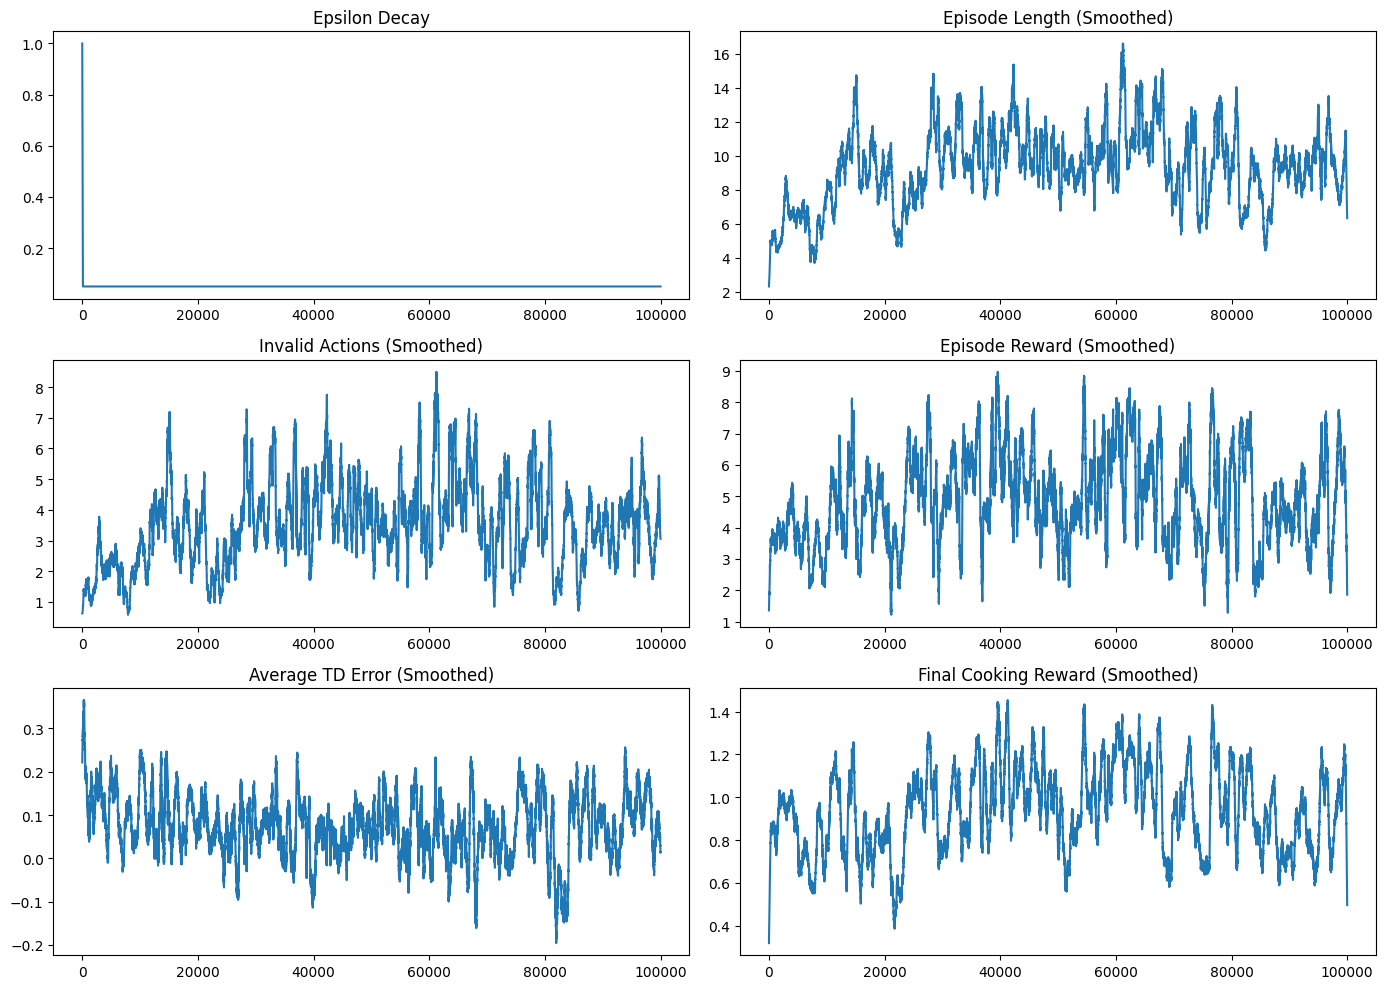

In [10]:
# Visualize training statistics of the SARSA agent
plot_agent_logs(sarsa_agent, wrapped_chef_env, episodes, use_td_errors=True)

In [11]:
# Print summary statistics of metrics collected during SARSA agent training
print_log_stats(sarsa_agent, use_td_errors=True)

Metric                          Mean        Std        Min        Max
---------------------------------------------------------------------------------
Epsilon Decay                   0.05       0.02       0.05       1.00
Episode Length                  9.35      12.08       1.00      50.00
Invalid Actions                 3.53      10.08       0.00      48.00
Episode Reward                  4.88      12.38     -52.91      34.23
Average TD Error                0.07       0.85      -9.02       2.06
Final Cooking Reward            0.94       1.11      -3.91       4.20


#### Comment

**Epsilon Decay:**  
Epsilon decayed rapidly, reaching the minimum value of **0.05** around the 100th episode. This shows that the agent **started with exploration** but quickly **shifted toward exploitation**.

**Episode Lengths:**  
Episode lengths are highly variable, with a **mean of approximately 9 steps** and a range from **1 to 50**.
- A length of **1** suggests the agent chose to cook immediately using only one ingredient.
- A length of **50** means the episode reached the **maximum step limit** and triggered automatic cooking ("autocook").  

The average of **9** is promising. It implies the agent **typically gathered multiple ingredients** and **rarely relied on default termination**.

**Invalid Actions:**  
The number of invalid actions per episode ranges from **0 to 48**, with an **average of about 4**.
- A count of **0** indicates well-informed behavior.
- Higher values suggest the agent **occasionally struggled with recognizing valid moves**.  

The relatively low mean suggests learning was effective over time, although **rare extreme cases** still occured.

**Episode Rewards:**  
Episode rewards vary widely, with a **mean of ~4.9**, a standard deviation of ~12.4, and values ranging from **-52.9 to 34.2**.
- Large **negative rewards** likely correspond to episodes with **many invalid actions** or **inefficient strategies**.
- The **high maximum** shows the agent was **capable of achieving strong outcomes**, but performance was inconsistent.

**TD Errors:**  
The TD errors average around **0.07** with a high standard deviation, and range from **-9 to 2.1**.
- The **negative lower bound** indicates significant **overestimations** of Q-values in some cases.
- The **high variability** suggests unstable or noisy learning signals, which may be typical during early training stages.

**Final Cooking Rewards:**  
Final cooking rewards have a **mean close to 1** and moderate variability.
- **Negative values** likely occured when the agent collected many ingredients but **failed to produce a valuable meal** (e.g., due to poor combinations or waste).
- The **positive maximum** suggests the agent managed sometimes to make highly rewarding dishes.

In [12]:
# Create a new environment instance for evaluation with verbose output
chef_env = gym.make("ChaoticChef-v0", recipes=recipes, index_to_ingredient=index_to_ingredient, verbose=True)

# Evaluate the trained SARSA agent by running one episode with its greedy policy
evaluate_agent(chef_env, sarsa_greedy_action(sarsa_agent))


Current position: 1 (red chilli powder)
Available actions: [(1, 'down'), (2, 'left'), (3, 'right'), (4, 'stop')]
Step: 1
Chosen: left (2), Executed: left (2), Slipped: False
Moved to: 0 (tomato)
Reward: 2

Current position: 0 (tomato)
Available actions: [(1, 'down'), (4, 'stop')]
Step: 2
Chosen: stop (4), Executed: stop (4), Slipped: False
Cooking. Ingredients: ['tomato', 'red chilli powder']
Best recipe matched: "Tagliatelle Pasta Recipe With Fresh Tomato Basil Sauce", Reward: 0.71

Total reward: 2.71, Steps taken: 2


### DQN (Deep Q-Network)

DQN is an **off-policy value-based reinforcement learning algorithm** that uses a **neural network** to approximate the action-value function Q(s,a). It is an extension of Q-learning, designed to handle **high-dimensional or continuous state spaces** where a tabular approach is impractical.

The Q-value is updated by maximizing the estimated value of the next state:

`Q[s, a] <- Q[s, a] + eta * (r + gamma * max_a' Q[s', a'] − Q[s, a])`

where:
- `eta` = **learning rate**
- `gamma` = **discount factor**
- `max_a' Q[s', a']` = the maximum predicted Q-value for the **next state** over all actions

Unlike SARSA, DQN is **off-policy**, meaning it updates using the **greedy action**, even if the agent explored during that transition.

To stabilize learning, DQN uses two techniques:
1. **Experience replay:** transitions are stored in a **replay buffer**, and mini-batches are sampled randomly to break correlations between sequential experiences.
2. **Target network:** a separate, **periodically-updated copy** of the Q-network is used to compute target values, reducing instability from rapidly shifting targets.

#### Double DQN (Double Deep Q-Network)

**Double DQN** improves upon DQN by **reducing overestimation bias** in Q-value updates. In DQN, the same network is used to both select and evaluate the best action, which can cause overly optimistic value estimates.

Double DQN **decouples** these steps by using:
- The **online network** to select the next action
- The **target network** to evaluate the value of that action

The update rule becomes:

`Q[s, a] <- Q[s, a] + eta * (r + gamma * Q_target[s', argmax_a' Q_online[s', a']] − Q[s, a])`

This structure leads to **more conservative and stable** learning, especially in environments where overestimation of Q-values can lead to **suboptimal behavior**.

In this project, the **Q-network** consisted of:
- **Two hidden layers** with **128 units** each, using **ReLU** activations
- Input: **one-hot encoded ingredient vector** representing the agent's current position

The DDQN agent was trained in the `ChaoticChef` environment for **100,000 episodes** using:
- `eta = 0.1`, `gamma = 0.99`
- **ε-greedy exploration**, with ε decaying by **0.01 per episode** to a minimum of **0.05**
- Target network updated every **10 episodes**
- Replay buffer of size **10,000** and batch size **64**

In [13]:
# Create the ChaoticChef environment without verbose output and wrap it for episode statistics recording
chef_env = gym.make("ChaoticChef-v0", recipes=recipes, index_to_ingredient=index_to_ingredient, verbose=False)

episodes = 100_000
wrapped_chef_env = gym.wrappers.RecordEpisodeStatistics(chef_env, buffer_length=episodes)

# Create and train a DDQN agent with specified hyperparameters for learning and exploration
state_dim = wrapped_chef_env.observation_space.n

ddqn_agent = DDQNAgent(
    env=wrapped_chef_env,
    state_dim=state_dim,
    lr=0.1,
    gamma=0.99,
    epsilon_min=0.05,
    epsilon_decay=0.01,
    batch_size=64,
    target_update_freq=10
    )

ddqn_agent.train(num_episodes=episodes, log_every=episodes)

Training: 100%|██████████| 100000/100000 [07:19<00:00, 227.46it/s]

Episode 100000 | Epsilon = 0.050 | Steps = 2 | Invalid Actions = 0 | Reward = -2.91 | Avg Loss = 0.5804 | Truncated = False | Cooking Reward = -1.91


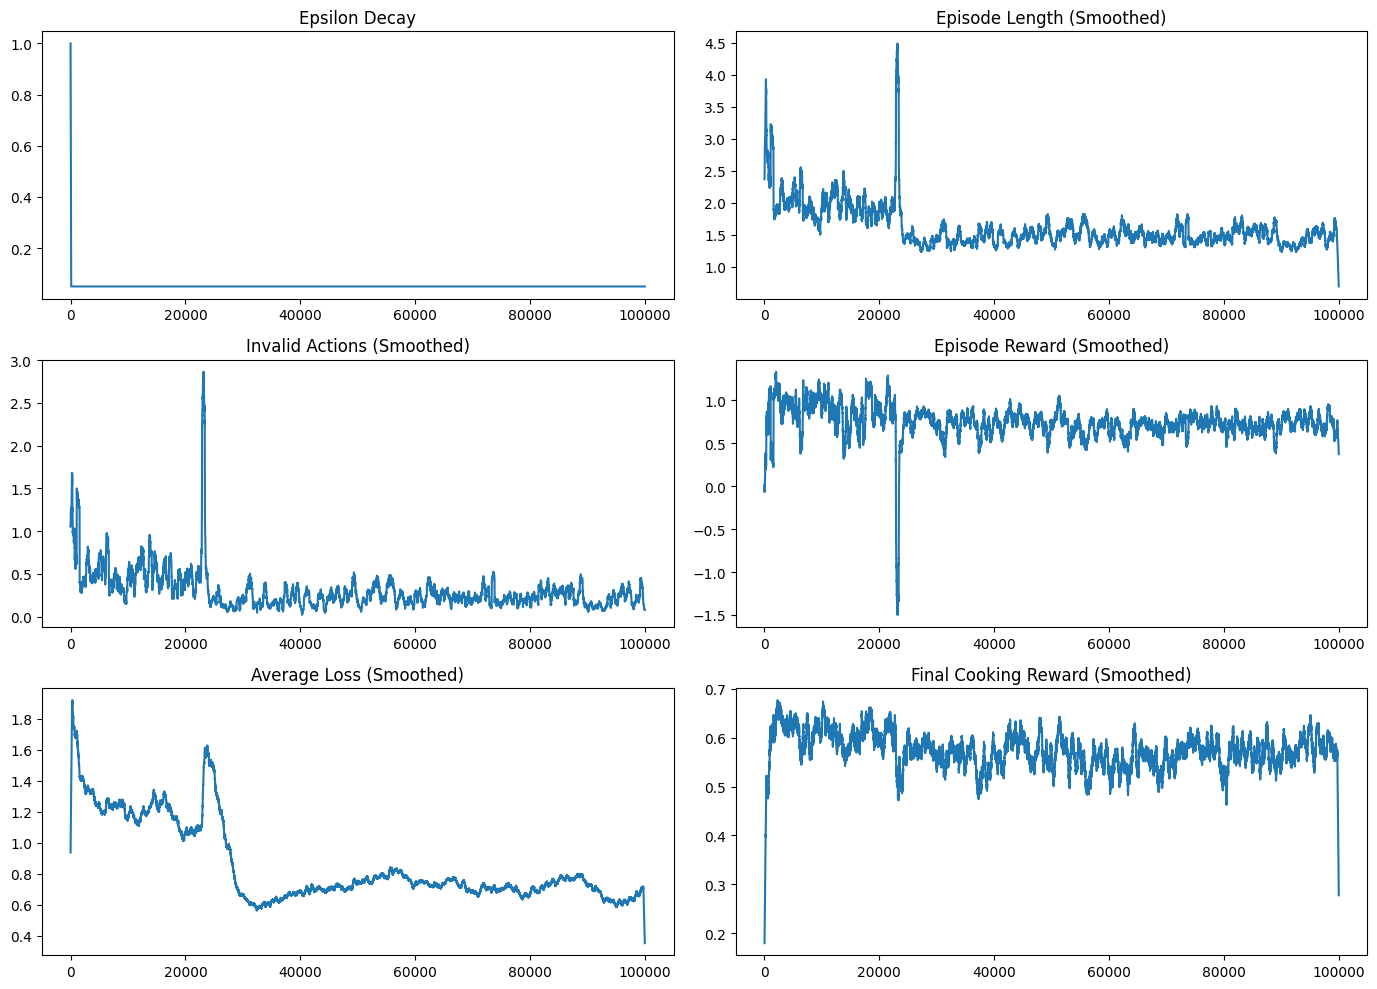

In [14]:
# Visualize training statistics of the DDQN agent
plot_agent_logs(ddqn_agent, wrapped_chef_env, episodes, use_td_errors=False)

In [15]:
# Print summary statistics of metrics collected during DDQN agent training
print_log_stats(ddqn_agent, use_td_errors=False)

Metric                          Mean        Std        Min        Max
---------------------------------------------------------------------------------
Epsilon Decay                   0.05       0.02       0.05       1.00
Episode Length                  1.62       2.66       1.00      50.00
Invalid Actions                 0.31       2.23       0.00      49.00
Episode Reward                  0.74       2.61     -52.91      16.84
Average Loss                    0.86       0.42       0.00       5.74
Final Cooking Reward            0.57       0.57      -3.91       3.09


##### Comment

**Episode Length:**  
The **mean episode length is around 2**, significantly lower than in the SARSA case (mean ~9). This suggests that the DDQN agent adopted a **more conservative strategy**, choosing to cook after collecting only a few ingredients. While this reduced the potential for high-reward combinations, it also **minimized risk**, such as collecting wasteful ingredients or triggering invalid moves. The **min and max values remain unchanged** (1 and 50), indicating the agent still occasionally cooked immediately or waited until the step limit.

**Invalid Actions:**  
The **average number of invalid actions is below 1**, a notable improvement over SARSA's mean of ~4. This indicates that the DDQN agent had become **better at recognizing valid moves**. However, the upper bound remains high (49), suggesting that while most episodes are clean, **some still exhibit poor decision-making**, possibly due to exploration, rare states, or slipping effects.

**Episode Reward:**  
The **lower average reward** compared to SARSA is consistent with the agent's more cautious behavior. By cooking earlier and avoiding complex ingredient combinations, the DDQN agent **sacrificed higher rewards** in favor of safer outcomes. The **lower maximum reward** also reflects this conservative strategy. The **minimum reward remains very low (-52.91)**, showing that bad episodes (with invalid actions or poor ingredient choices) still occur.

**Average Loss:**  
An **average loss of 0.86** indicates **moderate prediction error** during training. The **zero-loss minimum** corresponds to early training steps when the Q-network had not yet learned meaningful representations. The **maximum loss of 5.74** points to occasional spikes in prediction error, possibly due to rare or unexpected state-action pairs in the replay buffer.

**Final Cooking Reward:**  
The **mean cooking reward is slightly lower** and the **range is narrower** than with SARSA. This matches the agent's tendency to **cook conservatively**, prioritizing safer decisions and minimizing waste rather than attempting to maximize reward through riskier ingredient combinations.

In [16]:
# Create a new environment instance for evaluation with verbose output enabled
chef_env = gym.make("ChaoticChef-v0", recipes=recipes, index_to_ingredient=index_to_ingredient, verbose=True)

# Evaluate the trained DDQN agent by running one episode using its greedy policy
evaluate_agent(chef_env, ddqn_greedy_action(ddqn_agent))


Current position: 1 (red chilli powder)
Available actions: [(1, 'down'), (2, 'left'), (3, 'right'), (4, 'stop')]
Step: 1
Chosen: stop (4), Executed: stop (4), Slipped: False
Cooking. Ingredients: ['red chilli powder']
Best recipe matched: "Tagliatelle Pasta Recipe With Fresh Tomato Basil Sauce", Reward: 0.35

Total reward: 0.35, Steps taken: 1


#### Budgeted DDQN

To adapt the DDQN agent for the `BudgetedChaoticChef` environment, a subclass of `DDQNAgent` was implemented with a modified state representation. Instead of using only a one-hot encoded vector for the current ingredient, the input state was constructed by **concatenating**:
- A **one-hot vector** encoding the current ingredient
- A **normalized scalar** representing the remaining budget

This extended input allowed the agent to make budget-aware decisions. All other **components of the training setup**, such as the number of episodes, exploration strategy, and hyperparameters, **remained the same** as in the standard DDQN configuration.

In [17]:
# Initialize the budget-constrained ChaoticChef environment with costs and budget settings
budgeted_chef_env = gym.make(
    "BudgetedChaoticChef-v0",
    recipes=recipes,
    index_to_ingredient=index_to_ingredient,
    ingredient_to_cost=ingredient_to_cost,
    max_budget=15,
    revenue_multiplier=2.0,
    verbose=False)

# Wrap the environment to record episode statistics
episodes = 100_000
wrapped_budgeted_chef_env = gym.wrappers.RecordEpisodeStatistics(budgeted_chef_env, buffer_length=episodes)

# Create and train a budgeted DDQN agent with specified hyperparameters for learning and exploration
state_dim = wrapped_budgeted_chef_env.observation_space[0].n + 1

budgeted_ddqn_agent = BudgetedDDQNAgent(
    env=wrapped_budgeted_chef_env,
    state_dim=state_dim,
    lr=0.1,
    gamma=0.99,
    epsilon_min=0.05,
    epsilon_decay=0.01,
    batch_size=64,
    target_update_freq=10
    )

budgeted_ddqn_agent.train(num_episodes=episodes, log_every=episodes)

Training: 100%|██████████| 100000/100000 [11:33<00:00, 144.13it/s]

Episode 100000 | Epsilon = 0.050 | Steps = 3 | Invalid Actions = 0 | Reward = 3.45 | Avg Loss = 0.7374 | Truncated = False | Cooking Reward = -0.55


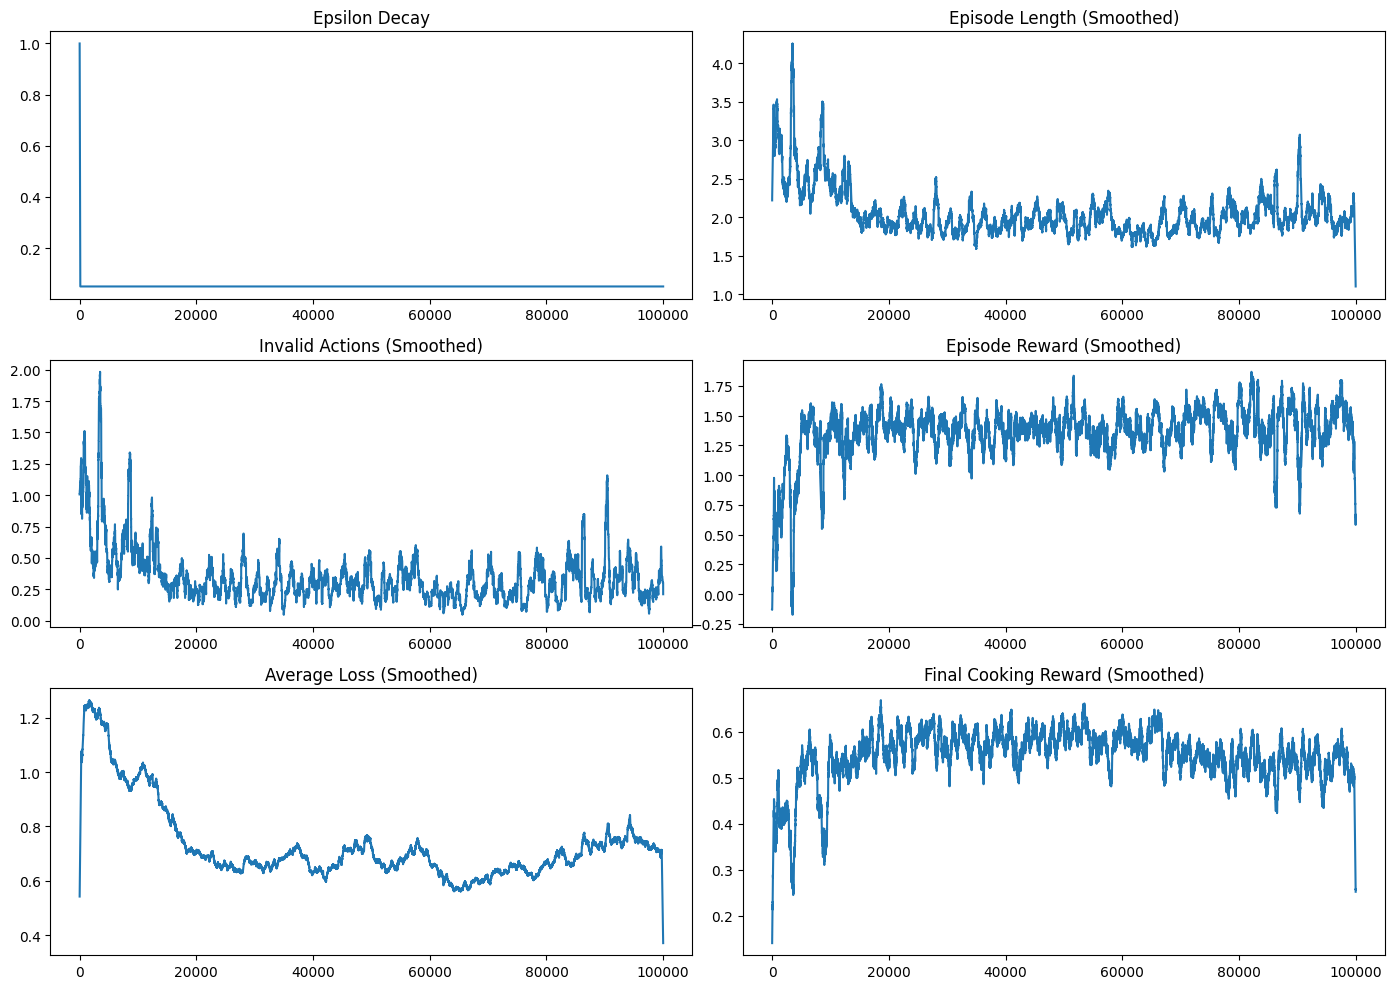

In [18]:
# Visualize training statistics of the budgeted DDQN agent
plot_agent_logs(budgeted_ddqn_agent, wrapped_budgeted_chef_env, episodes, use_td_errors=False)

In [19]:
# Print summary statistics of metrics collected during budgeted DDQN agent training
print_log_stats(budgeted_ddqn_agent, use_td_errors=False)

Metric                          Mean        Std        Min        Max
---------------------------------------------------------------------------------
Epsilon Decay                   0.05       0.02       0.05       1.00
Episode Length                  2.06       2.79       1.00      50.00
Invalid Actions                 0.35       2.48       0.00      49.00
Episode Reward                  1.36       3.05     -52.91      12.13
Average Loss                    0.73       0.23       0.00       3.04
Final Cooking Reward            0.55       0.63      -3.91       2.45


##### Comment

**Episode Length:**  
The average episode length slightly increased to around **2 steps**, compared to **1.62** in the standard DDQN case. This suggests that the **budget constraint led the agent to be slightly less conservative**, allowing it to collect more than one ingredient before cooking. However, the **minimum and maximum episode lengths remained unchanged**, indicating that while most episodes were still short, the agent occasionally used the full step limit.

**Invalid Actions:**  
The mean number of invalid actions is **approximately the same as before**, suggesting that the agent performed similarly in avoiding unaffordable or illegal moves. However, a **maximum of 49 invalid actions** in some episodes shows that occasional failures still occurred, likely due to repeated attempts in challenging budget conditions.

**Episode Reward:**  
The **mean reward is higher** than in the standard DDQN case, indicating that the agent was **more consistently successful despite the budget constraint**. However, the **maximum reward is lower**, suggesting that the budget limited the potential for very high-reward episodes. The **minimum reward remained unchanged**, showing that very poor episodes still occurred under some conditions.

**Average Loss:**  
The **mean loss slightly decreased**, and the overall **range narrowed**, indicating that the Q-value predictions were **more stable and consistent**.

**Final Cooking Reward:**  
This metric is **almost identical to the standard DDQN case**, but the **maximum is slightly lower**. This implies that while the agent usually cooked early, it was **slightly less successful** when collecting multiple ingredients, likely due to the added budget constraint limiting its options.

In [20]:
# Create a new environment instance for evaluation with verbose output enabled
budgeted_chef_env = gym.make(
    "BudgetedChaoticChef-v0",
    recipes=recipes,
    index_to_ingredient=index_to_ingredient,
    ingredient_to_cost=ingredient_to_cost,
    max_budget=15,
    revenue_multiplier=2.0,
    verbose=True)

# Evaluate the trained budgeted DDQN agent by running one episode using its greedy policy
evaluate_agent(budgeted_chef_env, ddqn_greedy_action(budgeted_ddqn_agent))


Current position: 19 (dry red chilli)
Current budget: 13.00
Valid and affordable actions: [(0, 'up'), (1, 'down'), (2, 'left'), (4, 'stop')]
Step: 1
Chosen: stop (4), Executed: stop (4), Slipped: False
Cooking. Ingredients: ['dry red chilli']
Best recipe matched: "Tagliatelle Pasta Recipe With Fresh Tomato Basil Sauce", Reward: 0.35, Revenue: 0.71
New budget: 13.71

Total reward: 0.35, Steps taken: 1


##### Comment

Comparing the results of training the SARSA agent and the DDQN agent in the `ChaoticChef` environment shows that, with a simple state representation (such as the grid position or its one-hot encoding), **tabular methods outperformed neural network-based approaches**.

While tabular SARSA showed more instability during training, it **encouraged more meaningful ingredient collection**. On the other hand, the DDQN agent often **converged to a conservative policy**, choosing to collect just one ingredient and cook immediately. This reduced the number of invalid actions but limited the potential for higher rewards.

Because the classic tabular SARSA algorithm could not be used in the `BudgetedChaoticChef` environment, due to the continuous budget variable and the resulting explosion in the number of possible states, a **linear approximation version of SARSA** was implemented instead.

### Linear SARSA (Function Approximation)

Linear SARSA is an **on-policy temporal-difference learning** algorithm that approximates the **action-value function Q(s, a)** using a **linear combination of features**. Instead of storing a Q-value for each state-action pair in a table, the algorithm maintains a **weight vector θ** and computes the Q-value as:

`Q(s, a) = θ · φ(s, a)`

where:
- `φ(s, a)` is a **feature vector** representing the state-action pair
- `θ` is the **weight vector** updated during learning

The weight update rule is derived from the SARSA TD error:

`θ <- θ + eta * (r + gamma * Q(s', a') − Q(s, a)) * φ(s, a)`

The update relies on the same transition tuple **(state, action, reward, next state, next action)** as in tabular SARSA. The difference is that the Q-values are now estimated with a linear function over features.

In this project, the linear SARSA agent was trained in the `BudgetedChaoticChef` environment. The state was encoded as a **concatenation of a one-hot ingredient vector and a normalized scalar representing the remaining budget**. This allowed the agent to handle the continuous budget dimension without enumerating all possible budget values.

The training was performed over **100,000 episodes** using the following parameters:
- `eta = 0.1` (learning rate)
- `gamma = 0.99` (discount factor)
- `ε` decayed linearly by **0.01 per episode** down to a minimum of **0.05**

In [21]:
# Initialize the budget-constrained ChaoticChef environment without verbose output and wrap it for episode statistics recording
budgeted_chef_env = gym.make(
    "BudgetedChaoticChef-v0",
    recipes=recipes,
    index_to_ingredient=index_to_ingredient,
    ingredient_to_cost=ingredient_to_cost,
    max_budget=15,
    revenue_multiplier=2.0,
    verbose=False)

episodes = 100_000
wrapped_budgeted_chef_env = gym.wrappers.RecordEpisodeStatistics(budgeted_chef_env, buffer_length=episodes)

# Create and train the budgeted linear SARSA agent with specified learning parameters
budgeted_linear_sarsa_agent = BudgetedLinearSARSAAgent(
    env=wrapped_budgeted_chef_env,
    eta=0.1,
    gamma=0.99,
    epsilon_min=0.05,
    epsilon_decay=0.01
    )

budgeted_linear_sarsa_agent.train(num_episodes=episodes, log_every=episodes)

Training: 100%|██████████| 100000/100000 [00:20<00:00, 4923.15it/s]

Episode 100000 | Epsilon = 0.050 | Steps = 1 | Invalid Actions = 0 | Reward = 0.35 | Avg TD Error = 0.2737 | Truncated = False | Cooking Reward = 0.35


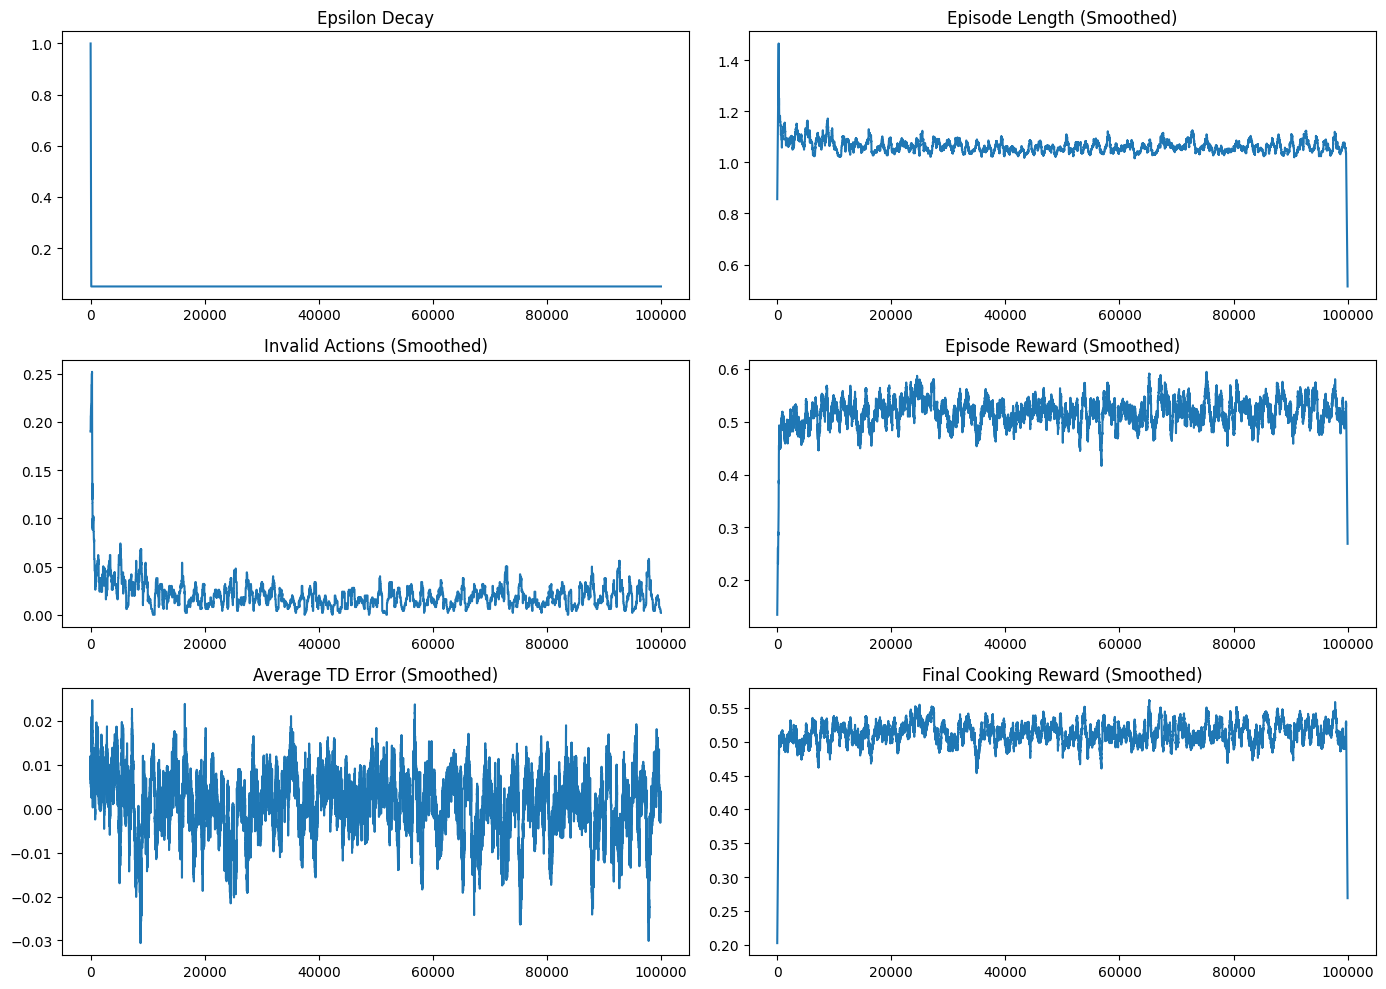

In [22]:
# Visualize training statistics of the budgeted linear SARSA agent
plot_agent_logs(budgeted_linear_sarsa_agent, wrapped_budgeted_chef_env, episodes, use_td_errors=True)

In [23]:
# Print summary statistics of metrics collected during budgeted linear SARSA agent training
print_log_stats(budgeted_linear_sarsa_agent, use_td_errors=True)

Metric                          Mean        Std        Min        Max
---------------------------------------------------------------------------------
Epsilon Decay                   0.05       0.02       0.05       1.00
Episode Length                  1.06       0.42       1.00      15.00
Invalid Actions                 0.02       0.24       0.00      10.00
Episode Reward                  0.52       0.60      -9.92       6.45
Average TD Error                0.00       0.30      -1.84       2.24
Final Cooking Reward            0.51       0.36      -2.73       2.45


#### Comment

**Episode Length:**  
This is the first agent for which the **maximum episode length remained below the step limit** of 50 throughout training, indicating that the agent never continued aimlessly until forced to stop. The **mean episode length of just over 1** confirms that the agent remained highly conservative, often choosing to cook immediately rather than explore further.

**Invalid Actions:**  
The **maximum number of invalid actions dropped significantly to 10**, compared to values above 40 in earlier models. The **average is nearly zero**, suggesting that the agent quickly learned which actions were legal and effectively avoided invalid moves.

**Episode Reward:**  
The **mean and maximum episode rewards are lower** compared to the budgeted DDQN, confirming that the linear SARSA agent was less effective at collecting valuable ingredient combinations. However, the **minimum reward is significantly less negative** (−9.92 vs −52.91), which is consistent with the lower number of invalid actions: fewer penalties led to fewer catastrophic failures.

**Average TD Error:**  
The **average temporal-difference error is exactly zero**, with a **smaller range** than observed in tabular SARSA in the non-budgeted environment. This suggests that the function approximation with linear features allowed for relatively stable learning.

**Final Cooking Reward:**  
The **mean and maximum final cooking rewards** are similar to the budgeted DDQN, but the **minimum value is slightly higher**, indicating that even when the agent attempted more than one step, it generally avoided completely wasting ingredients. This further supports the observation that the agent acted conservatively but more efficiently than before.

In [24]:
# Create a new environment instance for evaluation with verbose output
budgeted_chef_env = gym.make(
    "BudgetedChaoticChef-v0",
    recipes=recipes,
    index_to_ingredient=index_to_ingredient,
    ingredient_to_cost=ingredient_to_cost,
    max_budget=15,
    revenue_multiplier=2.0,
    verbose=True)

# Evaluate the trained budgeted linear SARSA agent by running one episode using its greedy policy
evaluate_agent(budgeted_chef_env, sarsa_greedy_action(budgeted_linear_sarsa_agent))


Current position: 20 (lemon juice)
Current budget: 13.00
Valid and affordable actions: [(0, 'up'), (3, 'right'), (4, 'stop')]
Step: 1
Chosen: stop (4), Executed: stop (4), Slipped: False
Cooking. Ingredients: ['lemon juice']
Best recipe matched: "Creamy Chicken Pesto Spaghetti Pasta Recipe", Reward: 0.49, Revenue: 0.98
New budget: 13.98

Total reward: 0.49, Steps taken: 1
